**PROJECT DATA ANALYSIS WITH THE BIOLOGICAL EVA™**

**SECTION 1 - BUSINESS UNDERSTANDING** In this notebook, we will analyze the data collected from the Biological EVA device in distinguishing between normal human urine, infected human urine and a control gas over two days. We will investigate if data collected from our sensors was successful in telling the difference between these three groups, if our model can be used on data collected on a different day, and if we're able to condense our data into less features to improve the performance of our model? 

Can the Biological EVA™ (BEVA) really smell bacteria in urine?



**QUESTION 1**: Are the sensors we are using effective in distinguishing between normal human urine, infected human urine, and lab air? 

**QUESTION 2:** Can we build a predictive classification model that can tell the difference between data collected on one day and tested on another?

**QUESTION 3:** Would condensing our data to be more efficient improve our model?

In [1]:
#Import all dependencies and files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import bevafun as b
%matplotlib inline 

**SECTION 2 - DATA GATHERING AND UNDERSTANDING**


In this step we will import the preprocessed features from sensors collected over two day (Days 1 and 2). The data contains no missing or null values, as it has already been preproccessed. Day 1 will represent  our Model Dataset and Day 2 is our holdout dataset. There should be 118 features and 1 label for each example. We will also perform some descriptive statistics to give us a range of values to expect from each feature position. 

In [2]:
#Load the Data Sources (Day 1 and 2)
df_day1 = pd.read_csv('./data/BEVA_Day1.csv', header=None)
df_day1.head()

df_day2 = pd.read_csv('./data/BEVA_Day2.csv', header=None)
df_day2.head()

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
0,99352.966292,59361.617978,131881.415730,507361.853933,942231.808989,-1259.168539,-129.146067,2488.808989,5145.471910,4280.134831,...,2.569066e+07,5.889510e+07,5.768402e+07,5.699499e+07,1812.949153,911698.949153,-43741.152542,-22072.406780,-7006.101695,1
1,99714.966292,59520.438202,132093.112360,508313.595506,943609.078652,-1259.797753,-129.797753,2493.887640,5163.314607,4290.359551,...,2.569655e+07,5.896026e+07,5.797968e+07,5.714938e+07,864.813559,926417.779661,-16853.016949,-23560.406780,-38073.152542,1
2,99791.741573,59581.089888,132374.112360,509283.112360,945116.415730,-1260.561798,-129.056180,2503.505618,5163.314607,4176.674157,...,2.573248e+07,5.906839e+07,5.796579e+07,5.714368e+07,1457.898305,920667.830508,-15902.033898,-8016.474576,14087.661017,1
3,66471.764045,41606.348315,88757.764045,313253.764045,563088.865169,-779.831461,-75.370787,1570.022472,2976.988764,2444.258427,...,2.298417e+07,5.271689e+07,5.148060e+07,5.053949e+07,1893.779661,832709.423729,-12715.525424,-14353.152542,4137.830508,1
4,69498.044944,43300.966292,92641.359551,329773.696629,597765.011236,-822.955056,-82.067416,1654.629213,3156.258427,2567.629213,...,2.341512e+07,5.368246e+07,5.241974e+07,5.136973e+07,1075.915254,850548.677966,-19853.559322,-17908.135593,-13451.118644,1


**DATA UNDERSTANDING** Some descriptive statistics about the datasets

In [ ]:
df_day1.describe()
df_day2.describe()

**DATA PREPARATION**

Changing the datatype of the values to float. Some data manipulation to read the data as matrices for easier use. We are also separating matrices into labels and features. 

In [4]:
df_day1= df_day1.astype('float')
day1_mat=df_day1.to_numpy()


day1_X=day1_mat[:,:-1]
day1_Y=day1_mat[:,-1]

df_day2= df_day2.astype('float')
day2_mat=df_day2.to_numpy()


day2_X=day2_mat[:,:-1]
day2_Y=day2_mat[:,-1]

**QUESTION 1**: Are the sensors we are using effective in distinguishing between normal human urine, infected human urine, and lab air? 

In order to answer this question we will visualize our dataset as clusters or "point clouds." Since we have so many data points, we will condense it using the Principal Component Analysis technique so we can visualize on an axis. If we are able to capture enough variance in our components and visualize these groups clearly on a set of axes, then the sensors we are using are good for this task!

Using the function from the BEVAFUN folder, we will pass the matrix which will be mormalized, then the variance will be calculated and displayed, returning the data frame for further handling. 

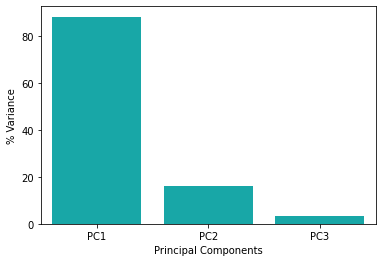

In [5]:
pc_df=b.pca_prep_plot(day1_mat)

The data from the PCA shows that we are able to condense our 118 features into 3 components while keeping the variance, that is promising! Now let us visualize this, if we see three distinct groups without overlap, then our sensors can tell this difference!

In [ ]:
sns.lmplot(x="PC1", y="PC2",
           data=pc_df, 
           fit_reg=False, 
           hue='Cluster', #label clusters with color
           legend=True,
           scatter_kws={"s": 100}) #point size 

We can see that there are three distinct clusters between Clusters 1 - Lab Air, 2 - Normal Human Urine, 3 - Infected Human Urine, therefore the selection of sensors are good for this task! 

**QUESTION 2** - Can we build a predictive classification model that can tell the difference between data collected on one day and tested on another?

Using our data collected from Day 1, we will train a classification model using the XGBOOST package and test it on an unseen dataset collected in the future (Day 2) to see if our data can tell the difference between these two days

**BUILD DAY 1 MODEL using 118 features**

In [ ]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(day1_Y)
model = XGBClassifier()
model.fit(day1_X,day1_Y)
print(model)

**TEST ON DATA FROM DAY 2**

In [ ]:
#do some predictive modeling

y_pred=model.predict(day2_X)
predictions = [round(value) for value in y_pred]

y_test = day2_Y
accuracy= accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

The model we created with our Day 1 dataset is able to classify data from Day 2 with > 85% accuracy! That means the models we build can work pretty well with data collected on a different day, and can be stable and efficient.

**QUESTION 3** Would condensing our data to be more efficient improve our model?

We have condensed our data previously with the PCA technique, now we will build a model with this data and test our condensed day 2 data to see if it will improve the accuracy of our model.

In [ ]:
model.fit(day1_pca,day1_Y)
print(model)

min_max_scaler = preprocessing.StandardScaler()
day2np_norm = min_max_scaler.fit_transform(day2_mat)
day2_df= pd.DataFrame(day2np_norm)

#PCA reduce to 2-3 important features 
pca = PCA(n_components=3)
day2_pca = pca.fit_transform(day2_df)

y_pred=model.predict(day2_pca)
predictions = [round(value) for value in y_pred]

#y_test = le.fit_transform(day2_Y)
y_test = day2_Y
accuracy= accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Using condensation techniques, the performance of our model improved! That means that condensing the variation and improving the efficiency by reducing the number of features is helpful in stabilizing our model to be tested on data collected over multiple days. 
